In [16]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from datetime import datetime
from tqdm import tqdm

In [17]:
ohlcv_cols = ['open', 'high', 'low', 'close', 'volume']
BTCUSDT15m = pd.read_parquet(r"C:\Users\USER\Documents\Tradingstuff\rawdatabinanceSOLUSDT-15m-data.parquet",columns=ohlcv_cols)
BTCUSDT = BTCUSDT15m.resample('1h').agg({'open':'first', 'high':'max', 'low':'min', 'close':'last', 'volume':'sum'})
BTCUSDT.head()

,open,high,low,close,volume
timestamp,,,,,
2023-01-01 00:00:00,9.968,10.016,9.923,9.979,2192047.0
2023-01-01 01:00:00,9.980,10.060,9.970,10.032,1386948.0
2023-01-01 02:00:00,10.031,10.074,9.981,10.006,1048577.0
2023-01-01 03:00:00,10.005,10.005,9.894,9.957,1629822.0
2023-01-01 04:00:00,9.957,9.978,9.810,9.837,1883235.0


Top 3 negative spikes at lags: [np.int64(2), np.int64(28), np.int64(1), np.int64(24)], Slopes: [np.float64(-0.01905542375777477), np.float64(-0.018770461331696252), np.float64(-0.01859522359239066), np.float64(-0.018329179342860238)]


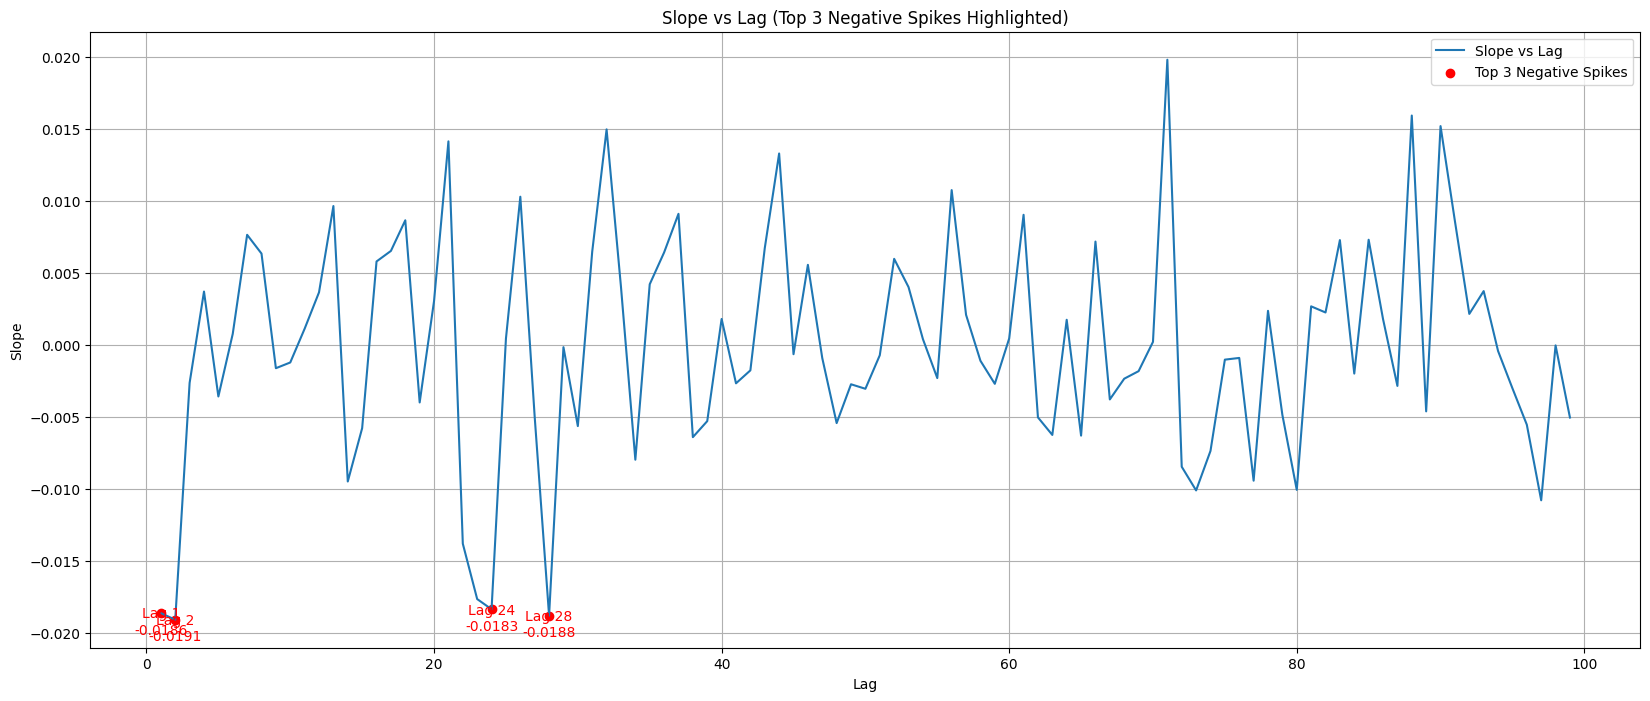

In [18]:
rets = np.array((BTCUSDT["close"] - BTCUSDT["open"]) / BTCUSDT["open"])
slopes = []
for lag in np.arange(1, 100):
    slope, intercept = np.polyfit(rets[:-lag], rets[lag:], 1)
    slopes.append(slope)

# Find top 3 negative spikes
import numpy as np
top3_idx = np.argsort(slopes)[:4]

min_idx = np.argmin(slopes)
print(f"Top 3 negative spikes at lags: {[i+1 for i in top3_idx]}, Slopes: {[slopes[i] for i in top3_idx]}")

plt.figure(figsize=(20,8))
plt.plot(np.arange(1, 100, 1), slopes, label='Slope vs Lag')
plt.scatter([i+1 for i in top3_idx], [slopes[i] for i in top3_idx], color='red', label='Top 3 Negative Spikes')
for i in top3_idx:
    plt.annotate(f'Lag {i+1}\n{slopes[i]:.4f}', (i+1, slopes[i]), textcoords="offset points", xytext=(0,-15), ha='center', color='red')
plt.xlabel('Lag')
plt.ylabel('Slope')
plt.title('Slope vs Lag (Top 3 Negative Spikes Highlighted)')
plt.legend()
plt.grid()
plt.show()

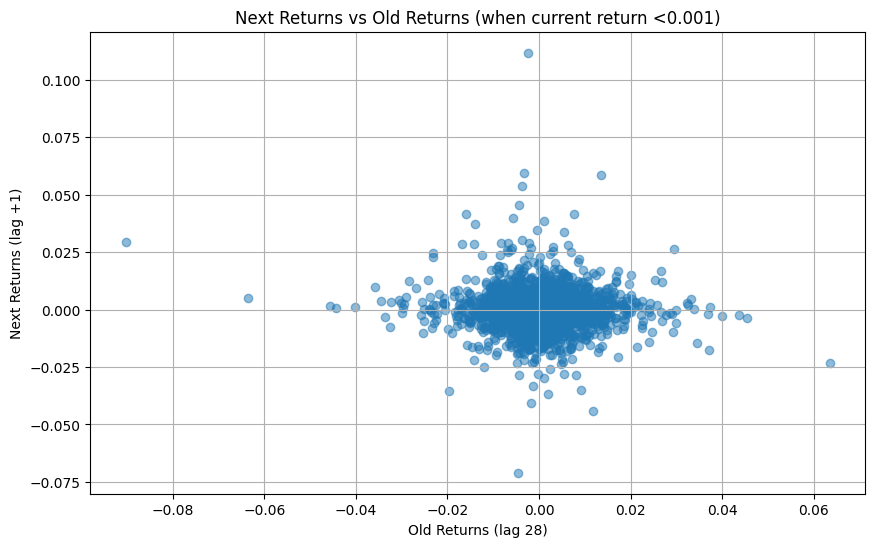

Slope: -0.04907, Intercept: 0.00013, R: -0.050, p-value: 0.0102


In [19]:
old_rets = []
next_rets = []

n=28
for i in range(n, len(rets)-1):
    if abs(rets[i]) < 0.001:
        old_rets.append(rets[i-n])
        next_rets.append(rets[i+1])

# Plot next_rets against old_rets
plt.figure(figsize=(10,6))
plt.scatter(old_rets, next_rets, alpha=0.5)
plt.xlabel(f'Old Returns (lag {n})')
plt.ylabel('Next Returns (lag +1)')
plt.title('Next Returns vs Old Returns (when current return <0.001)')
plt.grid()
plt.show()

# Find the slope (linear regression)
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(old_rets, next_rets)
print(f"Slope: {slope:.5f}, Intercept: {intercept:.5f}, R: {r_value:.3f}, p-value: {p_value:.3g}")

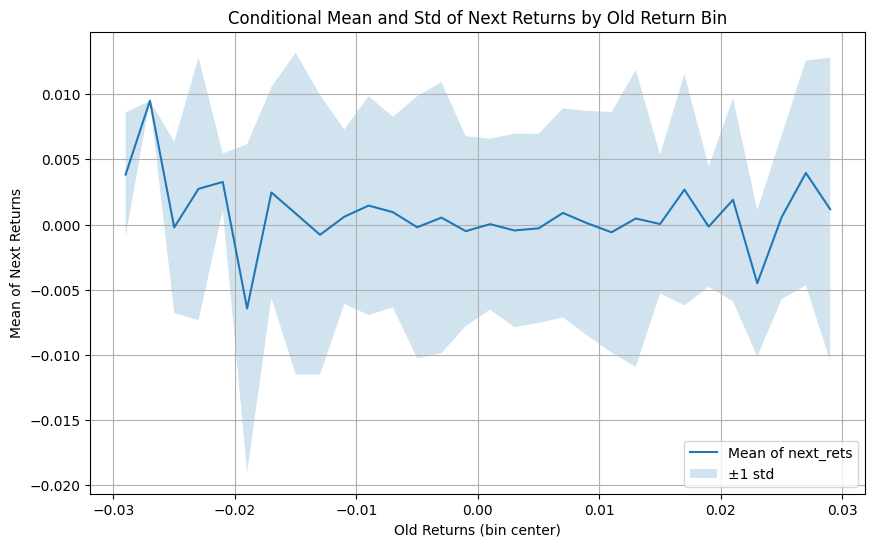

In [20]:
old_rets = np.array(old_rets)
next_rets = np.array(next_rets)

means = []
stds = []
bins = np.arange(-0.03, 0.03, 0.002)
for cur_ret in bins:
    temp = next_rets[(old_rets >= cur_ret) & (old_rets <= cur_ret + 0.002)]
    means.append(np.nanmean(temp))
    stds.append(np.nanstd(temp))

plt.figure(figsize=(10,6))
plt.plot(bins + 0.001, means, label='Mean of next_rets')
plt.fill_between(bins + 0.001, np.array(means)-np.array(stds), np.array(means)+np.array(stds), alpha=0.2, label='±1 std')
plt.xlabel('Old Returns (bin center)')
plt.ylabel('Mean of Next Returns')
plt.title('Conditional Mean and Std of Next Returns by Old Return Bin')
plt.grid()
plt.legend()
plt.show()

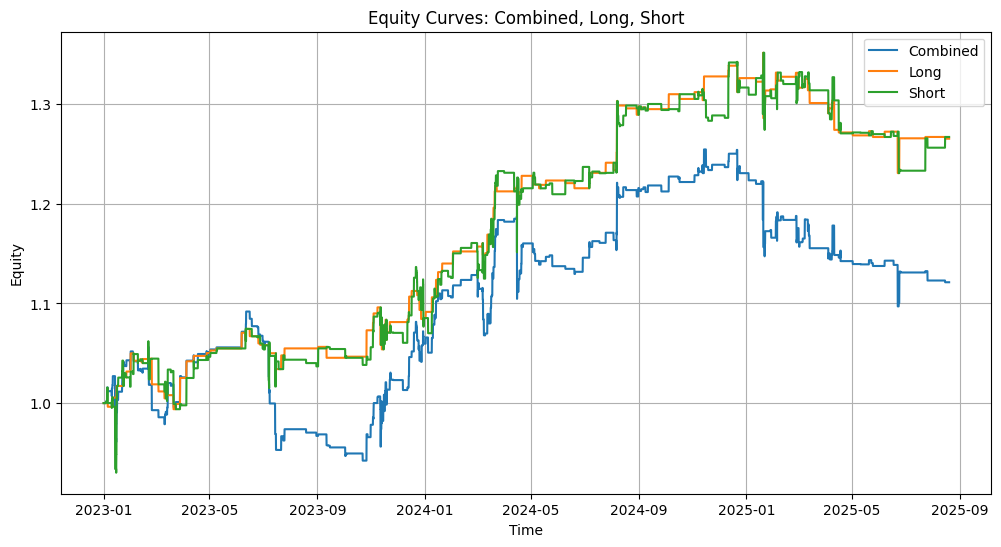

In [22]:
equity_combined = [1]
equity_long = [1]
equity_short = [1]
fees = 0.0005

for i in range(len(BTCUSDT)-1):
    if rets[i-n] < -0.026 and abs(rets[i-1]) < 0.01:
        equity_combined.append(equity_combined[i] + rets[i] - fees)
        equity_long.append(equity_long[i] + rets[i] - fees)
        equity_short.append(equity_long[i])
    elif rets[i-n] > 0.026 and abs(rets[i-1]) < 0.01:
        equity_combined.append(equity_combined[i] - rets[i] - fees)
        equity_long.append(equity_long[i])
        equity_short.append(equity_short[i] - rets[i] - fees)
    else:
        equity_combined.append(equity_combined[i])
        equity_long.append(equity_long[i])
        equity_short.append(equity_short[i])

# Plot the three equity curves with proper time axis
time_index = BTCUSDT.index[1:len(equity_combined)+1] if len(BTCUSDT.index) > len(equity_combined) else BTCUSDT.index[:len(equity_combined)]
plt.figure(figsize=(12,6))
plt.plot(time_index, equity_combined, label='Combined')
plt.plot(time_index, equity_long, label='Long')
plt.plot(time_index, equity_short, label='Short')
plt.xlabel('Time')
plt.ylabel('Equity')
plt.title('Equity Curves: Combined, Long, Short')
plt.legend()
plt.grid()
plt.show()